## 5.1 Correlation Analysis

I directly used the dataset generated in Part A, where adverse events were extracted and classified.

### 5.1.1 Correlations Between Variables

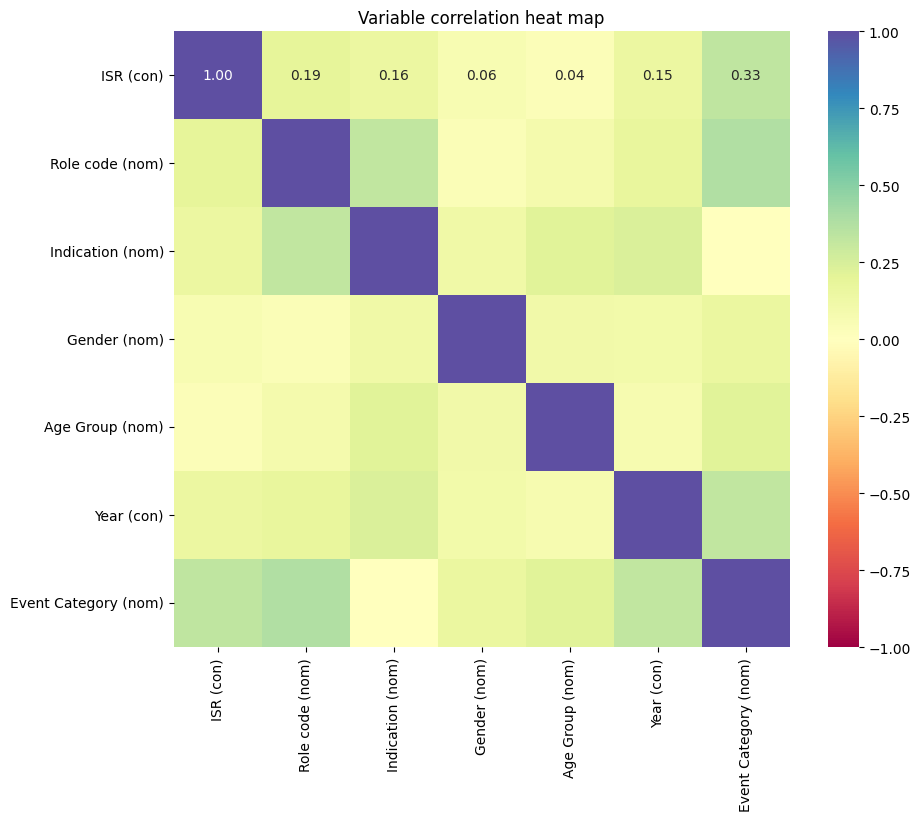

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from dython import nominal

data_3 = pd.read_csv('classified_data.csv')

selected_vars = ['ISR', 'Role code', 'Indication', 'Gender', 'Age Group', 'Year', 'Event Category']
data_3 = data_3[selected_vars]

data_3 = data_3.dropna()

data_3['Year'] = pd.to_numeric(data_3['Year'], errors='coerce')

data_3 = data_3.dropna()

categorical_vars = ['Role code', 'Indication', 'Gender', 'Age Group', 'Event Category']
for col in categorical_vars:
    data_3[col] = data_3[col].astype(str)

associations = nominal.associations(
    data_3,
    nominal_columns=categorical_vars,
    figsize=(10, 8),
    mark_columns=True,
    cmap='Spectral',
    annot=True,
    fmt='.2f',
    title='Variable correlation heat map'
)

plt.show()


### 5.1.2 Correlations Between Adverse Events


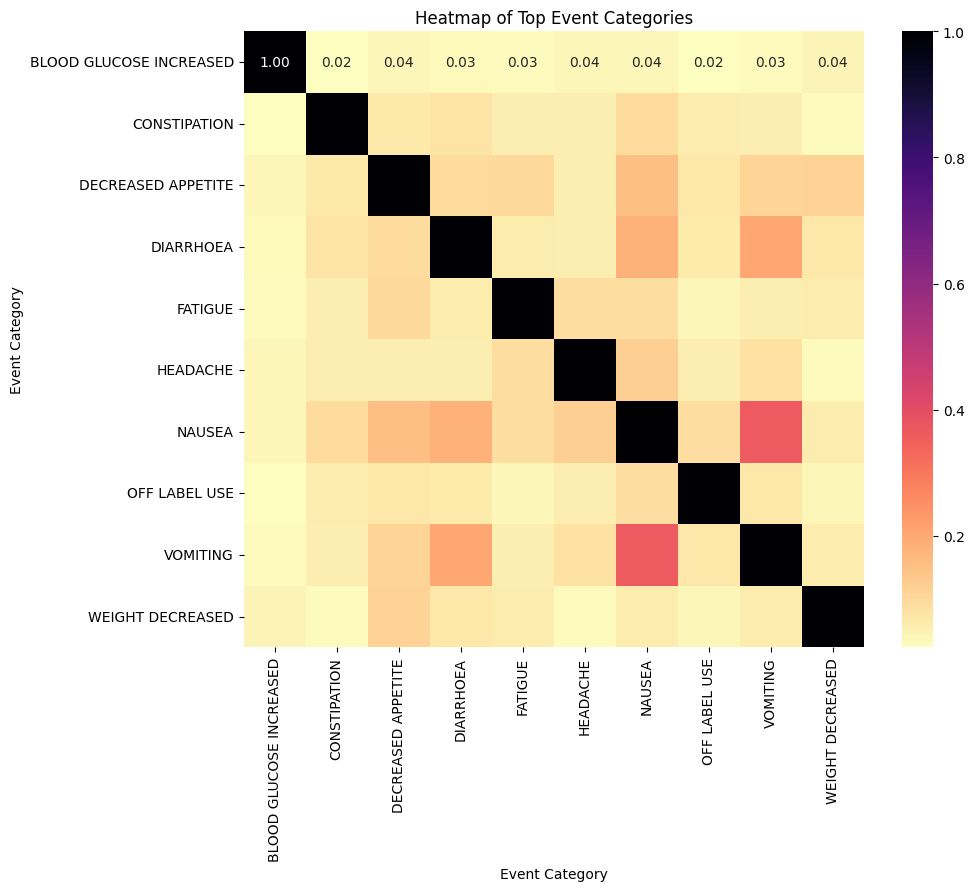

In [25]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


event_category_counts = data_3['Event Category'].value_counts()

top_10_event_categories = event_category_counts.head(10).index

filtered_data = data_3[data_3['Event Category'].isin(top_10_event_categories)]

event_category_matrix = pd.crosstab(filtered_data['ISR'], filtered_data['Event Category'])

jaccard_matrix = pd.DataFrame(index=event_category_matrix.columns, columns=event_category_matrix.columns)

for cat1 in event_category_matrix.columns:
    for cat2 in event_category_matrix.columns:
        intersection = (event_category_matrix[cat1] & event_category_matrix[cat2]).sum()  # A ∩ B
        union = (event_category_matrix[cat1] | event_category_matrix[cat2]).sum()  # A ∪ B
        if union == 0:
            jaccard_matrix.loc[cat1, cat2] = 0  # Avoid division by zero
        else:
            jaccard_matrix.loc[cat1, cat2] = intersection / union

plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix.astype(float), annot=True, cmap='magma_r', fmt='.2f')
plt.title('Heatmap of Top Event Categories')
plt.show()



## 5.2 Topic Modeling Results

### 5.2.1 Selection of the Optimal Model

#### LDA Model

LDA Model with 2 Topics, alpha='symmetric', Coherence Score: 0.5099
LDA Model with 2 Topics, alpha='asymmetric', Coherence Score: 0.5796
LDA Model with 2 Topics, alpha='auto', Coherence Score: 0.4860
LDA Model with 3 Topics, alpha='symmetric', Coherence Score: 0.5433
LDA Model with 3 Topics, alpha='asymmetric', Coherence Score: 0.5729
LDA Model with 3 Topics, alpha='auto', Coherence Score: 0.5050
LDA Model with 4 Topics, alpha='symmetric', Coherence Score: 0.5230
LDA Model with 4 Topics, alpha='asymmetric', Coherence Score: 0.5096
LDA Model with 4 Topics, alpha='auto', Coherence Score: 0.4494
LDA Model with 5 Topics, alpha='symmetric', Coherence Score: 0.4579
LDA Model with 5 Topics, alpha='asymmetric', Coherence Score: 0.4654
LDA Model with 5 Topics, alpha='auto', Coherence Score: 0.4526

Best LDA Model:
num_topics                  2
alpha              asymmetric
coherence_score      0.579638
Name: 1, dtype: object


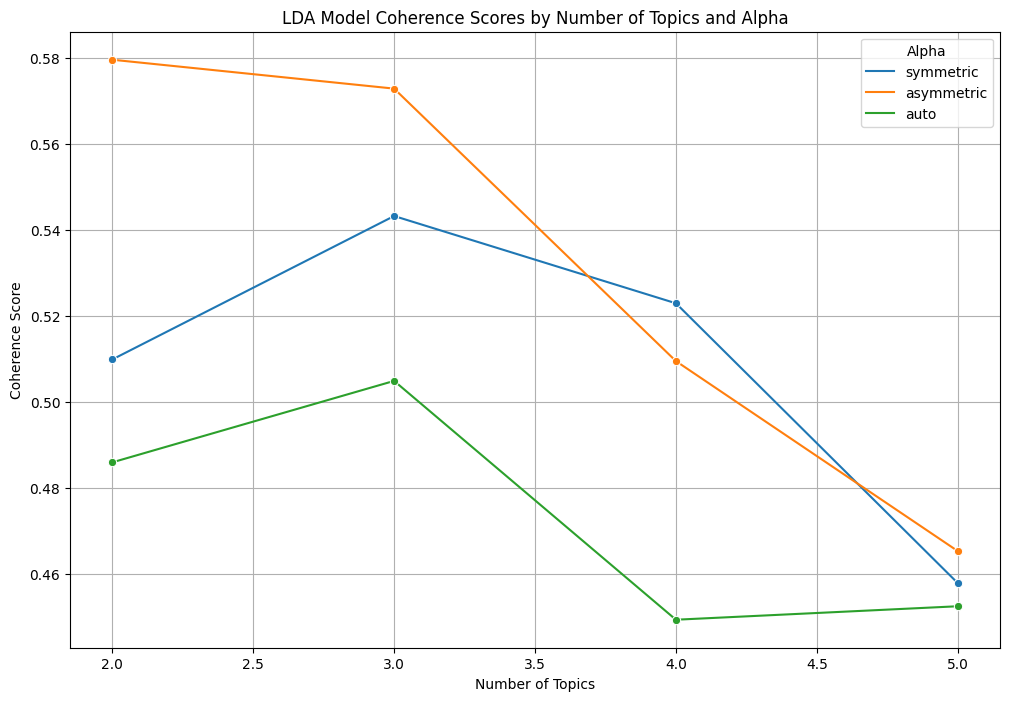

Topic 1: 0.055*"nausea" + 0.037*"abdominal" + 0.037*"vomiting" + 0.036*"pain" + 0.034*"blood" + 0.027*"diarrhoea" + 0.022*"disorder" + 0.021*"weight" + 0.019*"glucose" + 0.019*"appetite"
Topic 2: 0.041*"pain" + 0.022*"infection" + 0.018*"rash" + 0.017*"covid" + 0.017*"swelling" + 0.015*"skin" + 0.014*"pruritus" + 0.014*"arthralgia" + 0.012*"discomfort" + 0.011*"hepatic"


In [26]:
# Import necessary libraries
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
data_4 = pd.read_csv('classified_data.csv')  # Ensure the file name and path are correct

# 2. Remove duplicates based on 'Case_id'
data_4 = data_4.drop_duplicates(subset='Case_id')

# 3. Select necessary columns and drop missing values
data_4 = data_4[['Case_id', 'Cleaned_Text', 'Year']].dropna()

# 4. Define standard and custom stop words
stop_words = set(stopwords.words('english'))
custom_stop_words = [
    'use', 'product', 'label', 'indication', 'site', 'injection', 'increased', 'decreased',
    'process', 'technique', 'usage', 'administration', 'wrong', 'administered', 'issue',
    'device', 'unapproved', 'dose'
]
stop_words.update(custom_stop_words)

# 5. Text preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lower case
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return tokens

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# 6. Apply preprocessing to the 'Cleaned_Text' column
data_4['tokens'] = data_4['Cleaned_Text'].apply(preprocess_text)

# 7. Create dictionary and corpus using filtered tokens
dictionary = Dictionary(data_4['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in data_4['tokens']]

# 8. Define hyperparameter grid (excluding eta)
num_topics_list = list(range(2, 6))  
alpha_values = ['symmetric', 'asymmetric', 'auto']  # Alpha parameters

# Initialize lists to store results
model_results = []
coherence_scores = []

# 9. Grid Search over hyperparameters (only num_topics and alpha)
for num_topics in num_topics_list:
    for alpha in alpha_values:
        # Train LDA model
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha=alpha,
            eta='auto'  # Keep eta fixed as 'auto'
        )
        
        # Calculate Coherence Score
        coherence_model_lda = CoherenceModel(
            model=lda_model,
            texts=data_4['tokens'],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_lda = coherence_model_lda.get_coherence()
        
        # Append results
        model_results.append({
            'num_topics': num_topics,
            'alpha': alpha,
            'coherence_score': coherence_lda
        })
        print(f"LDA Model with {num_topics} Topics, alpha='{alpha}', Coherence Score: {coherence_lda:.4f}")

# 10. Convert results to DataFrame
results_df = pd.DataFrame(model_results)

# 11. Find the best model
best_model = results_df.loc[results_df['coherence_score'].idxmax()]
print("\nBest LDA Model:")
print(best_model)

# 12. Plot coherence scores
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='num_topics', y='coherence_score', hue='alpha', marker='o')
plt.title('LDA Model Coherence Scores by Number of Topics and Alpha')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(title='Alpha')
plt.grid(True)
plt.show()

# 13. Train the best model again (optional)
optimal_num_topics = best_model['num_topics']
optimal_alpha = best_model['alpha']

best_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    random_state=42,
    passes=10,
    alpha=optimal_alpha,
    eta='auto'
)

# 14. Display the topics of the best model
for idx, topic in best_lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

In [27]:
best_lda_model.save(f'best_lda_model_{int(optimal_num_topics)}_topics.model')

#### NMF Model


NMF Model with 2 Topics, init='nndsvd', Coherence Score: 0.7249
NMF Model with 2 Topics, init='random', Coherence Score: 0.7249
NMF Model with 3 Topics, init='nndsvd', Coherence Score: 0.7018
NMF Model with 3 Topics, init='random', Coherence Score: 0.5948
NMF Model with 4 Topics, init='nndsvd', Coherence Score: 0.6583
NMF Model with 4 Topics, init='random', Coherence Score: 0.6583
NMF Model with 5 Topics, init='nndsvd', Coherence Score: 0.6385
NMF Model with 5 Topics, init='random', Coherence Score: 0.6562

Best NMF Model:
num_topics                2
init                 nndsvd
coherence_score    0.724895
Name: 0, dtype: object


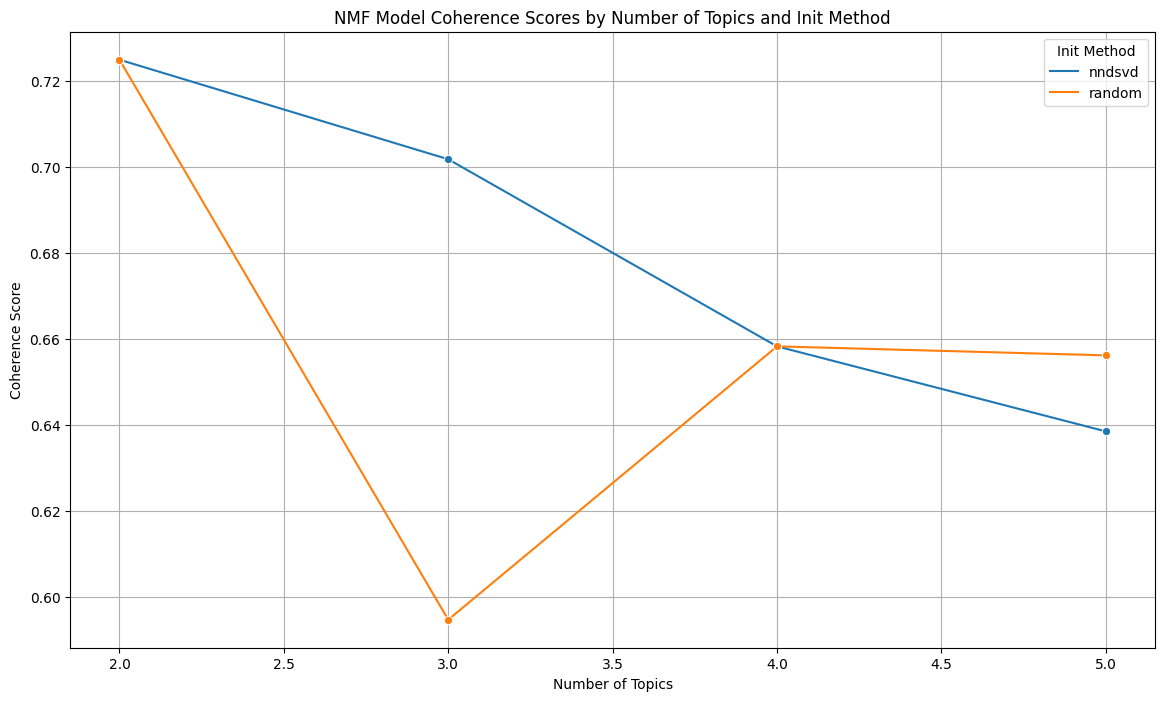

Topic 1: nausea, vomiting, abdominal, diarrhoea, pain, appetite, upper, headache, constipation, weight
Topic 2: blood, glucose, weight, pressure, drug, abnormal, appetite, ineffective, dizziness, omission


In [28]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

data_4['processed_text'] = data_4['tokens'].apply(lambda x: ' '.join(x))

# Verify 'processed_text' column exists
if 'processed_text' not in data_4.columns:
    raise KeyError("'processed_text' column is missing.")

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
tfidf = vectorizer.fit_transform(data_4['processed_text'])
tfidf_feature_names = vectorizer.get_feature_names_out()

# Create dictionary for coherence
dictionary = Dictionary(data_4['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Define hyperparameter grid for NMF (excluding 'nndsvda')
num_topics_list = list(range(2, 6)) 
init_methods = ['nndsvd', 'random']  # Initialization methods

# Initialize list to store results
nmf_results = []

# Grid search over number of topics and initialization methods
for num_topics in num_topics_list:
    for init in init_methods:
        # Train NMF model
        nmf_model = NMF(
            n_components=num_topics,
            random_state=42,
            init=init,
            max_iter=200
        )
        W = nmf_model.fit_transform(tfidf)
        H = nmf_model.components_
        
        # Extract top 10 words for each topic
        topics_tokens = []
        for topic in H:
            top_features_indices = topic.argsort()[:-11:-1]
            top_features = [tfidf_feature_names[i] for i in top_features_indices]
            topics_tokens.append(top_features)
        
        # Calculate Coherence Score
        coherence_model_nmf = CoherenceModel(
            topics=topics_tokens,
            texts=data_4['tokens'],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_nmf = coherence_model_nmf.get_coherence()
        
        # Store the results
        nmf_results.append({
            'num_topics': num_topics,
            'init': init,
            'coherence_score': coherence_nmf
        })
        print(f"NMF Model with {num_topics} Topics, init='{init}', Coherence Score: {coherence_nmf:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(nmf_results)

# Find the best model based on highest coherence score
best_model = results_df.loc[results_df['coherence_score'].idxmax()]
print("\nBest NMF Model:")
print(best_model)

# Plot coherence scores
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=results_df,
    x='num_topics',
    y='coherence_score',
    hue='init',
    marker='o'
)
plt.title('NMF Model Coherence Scores by Number of Topics and Init Method')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(title='Init Method')
plt.grid(True)
plt.show()

# Train the best NMF model again (optional)
optimal_num_topics = best_model['num_topics']
optimal_init = best_model['init']

best_nmf_model = NMF(
    n_components=optimal_num_topics,
    random_state=42,
    init=optimal_init,
    max_iter=200
)
W_best = best_nmf_model.fit_transform(tfidf)
H_best = best_nmf_model.components_

# Display the topics of the best model
for idx, topic in enumerate(H_best):
    top_features_indices = topic.argsort()[:-11:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_indices]
    print(f"Topic {idx + 1}: {', '.join(top_features)}")


In [29]:
import joblib
joblib.dump(best_nmf_model, f'best_nmf_model_{int(optimal_num_topics)}_topics.pkl')


['best_nmf_model_2_topics.pkl']


### 5.2.2 Analysis of Identified Topics

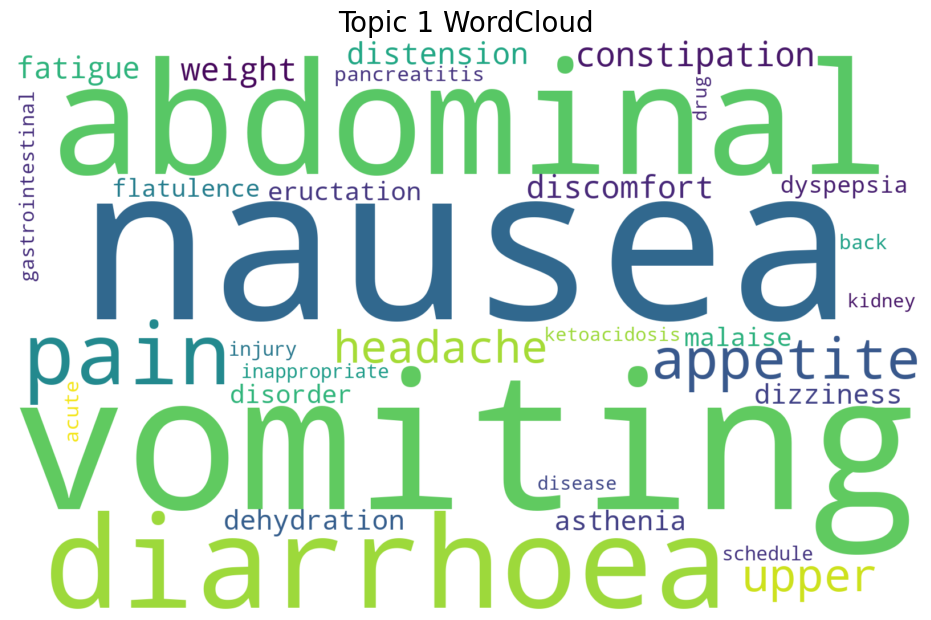

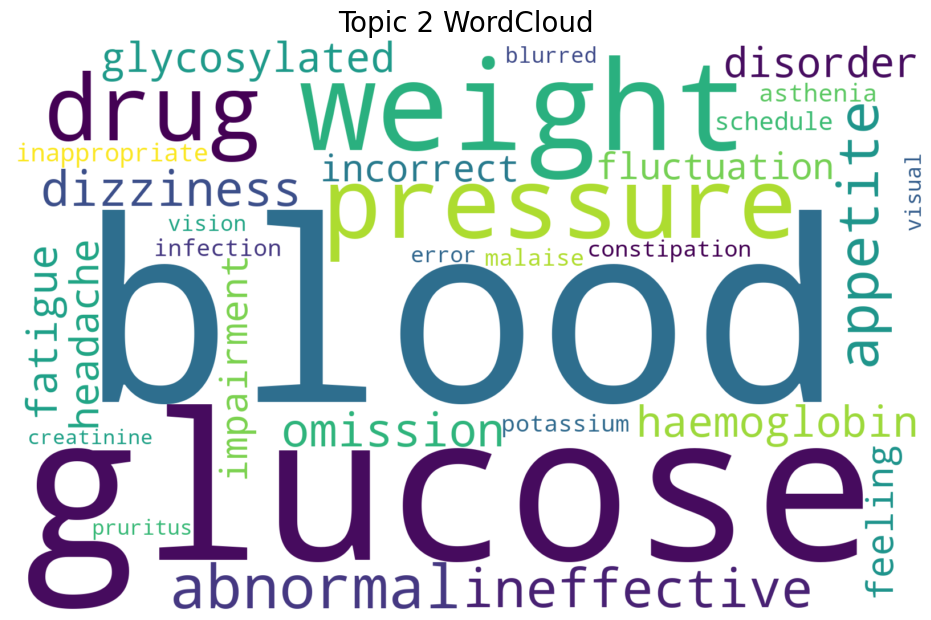

In [54]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Get H (topic-word matrix) from the best model
H_best = best_nmf_model.components_

# Generate and display word clouds for each topic
for topic_idx, topic in enumerate(H_best):
    # Get indices of the top 50 words for the topic
    top_features_indices = topic.argsort()[:-51:-1]
    # Create a dictionary of word frequencies
    top_features = {tfidf_feature_names[i]: topic[i] for i in top_features_indices}
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=1600,
        height=1000,
        background_color='white',
        max_words=32
    ).generate_from_frequencies(top_features)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6), dpi=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx+1} WordCloud', fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()


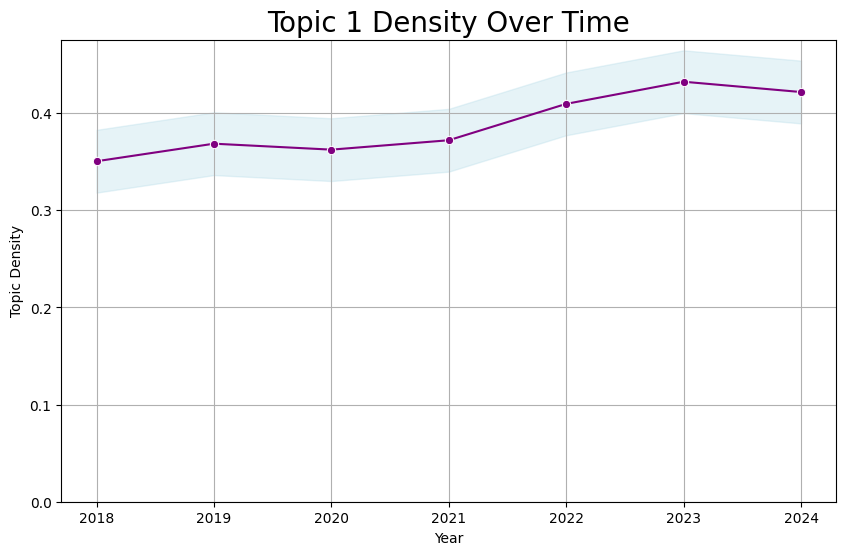

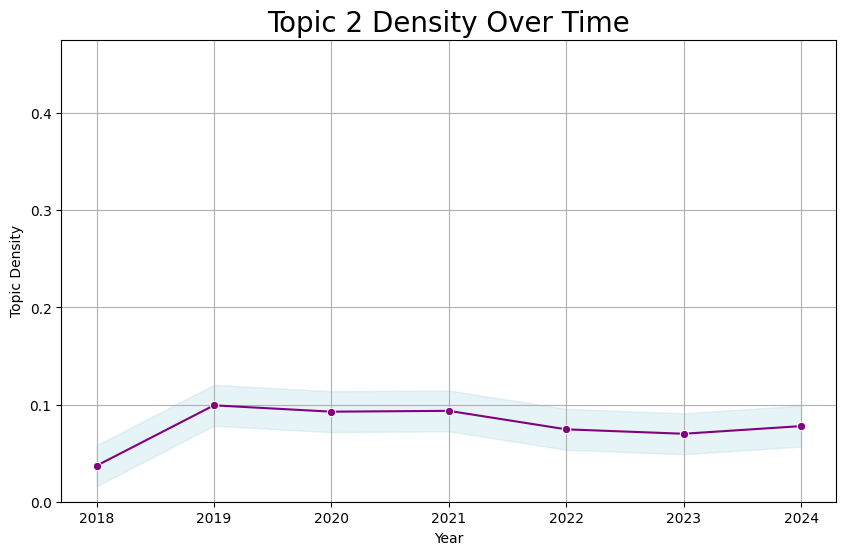

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Year' is in integer format
data_4['Year'] = pd.to_datetime(data_4['Year'], format='%Y')
data_4['Year'] = data_4['Year'].dt.year

# Assign dominant topic to each document using the correct W
dominant_topics = W.argmax(axis=1)
data_4['dominant_topic'] = dominant_topics

# Group data by Year and dominant_topic
topic_year_density = data_4.groupby(['Year', 'dominant_topic']).size().reset_index(name='count')

# Compute total counts per year
yearly_counts = data_4['Year'].value_counts().sort_index()

# Normalize the count per year to get density
topic_year_density['density'] = topic_year_density.apply(
    lambda row: row['count'] / yearly_counts[row['Year']], axis=1
)

# Optionally, filter only the top 3 topics
top_topics = topic_year_density['dominant_topic'].unique()[:2]  # Get first 3 topics
top_topics_data = topic_year_density[topic_year_density['dominant_topic'].isin(top_topics)]

# Define consistent y-axis range (0 to maximum density across all topics)
y_min, y_max = 0, top_topics_data['density'].max() * 1.1  # Adding 10% margin for better visibility

# Plot the density trend for each of the top topics
for topic in top_topics:
    plt.figure(figsize=(10, 6))
    topic_data = top_topics_data[top_topics_data['dominant_topic'] == topic]
    
    sns.lineplot(data=topic_data, x='Year', y='density', marker='o', color='purple')
    plt.fill_between(topic_data['Year'], 
                     topic_data['density'] - topic_data['density'].std(), 
                     topic_data['density'] + topic_data['density'].std(), 
                     color='lightblue', alpha=0.3)
    
    plt.title(f'Topic {topic + 1} Density Over Time', fontsize=20)
    plt.xlabel('Year')
    plt.ylabel('Topic Density')
    plt.ylim(y_min, y_max)  # Standardize y-axis range
    plt.grid(True)
    plt.show()
